# Setup

In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from torch.utils.data import random_split
import torch
from sklearn.metrics import (
    confusion_matrix, 
    f1_score, 
    accuracy_score, 
    recall_score,
    precision_score,
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)
import seaborn as sns
import logging
import json
logging.getLogger().setLevel(logging.INFO)

In [20]:
# CONFIGURATION
random_seed = 42
data_filepath = "./data/train_auto_annotations_UPDATED_cleaned2.csv"
model_params = dict()
label_cols = ["svo_dist", "svo_dist_norm", "apv", "scv", "hv", "svo_dist_norm_disc5", "svo_dist_norm_disc20", "svo_dist_norm_disc20"]
tasks = ["regression", "regression", "classification", "classification", "classification", "classification", "classification", "classification"]
num_classes_list = [1, 1, 3, 3, 3, 5, 10, 20]
sent_col = "sent_cleaned"

# Load Data

In [21]:
df = pd.read_csv(data_filepath, index_col=0)
df.head()
df.shape

(31740, 13)

In [22]:
df.columns

Index(['sent-index', 'sent', 'svo_dist', 'apv', 'scv', 'hv', 'svo_dist_norm',
       'svo_dist_norm_disc5', 'svo_dist_norm_disc10', 'svo_dist_norm_disc20',
       'sent_cleaned', 'tokens', 'sent_lemm'],
      dtype='object')

# Data Preprocess

In [23]:
# For classification tasks, transform labels into label indexes
# Create y_dict which contains labels for each task
labels_dict = {}
label_counts_dict = {}
y_dict = {}
for label_col, task in zip(label_cols, tasks):
    if task == "classification":
        labels, label_idxs, label_counts = np.unique(
            df[label_col], return_inverse=True, return_counts=True
        )
        labels_dict[label_col] = labels
        label_counts_dict[label_col] = label_counts
        df[f"{label_col}_idx"] = label_idxs
        y_dict[label_col] = df[f"{label_col}_idx"].to_numpy()
    else:
        y_dict[label_col] = df[label_col].to_numpy()
df.head()

,sent-index,sent,svo_dist,apv,scv,hv,svo_dist_norm,svo_dist_norm_disc5,svo_dist_norm_disc10,svo_dist_norm_disc20,sent_cleaned,tokens,sent_lemm,apv_idx,scv_idx,hv_idx,svo_dist_norm_disc5_idx,svo_dist_norm_disc20_idx
0,0_66252-0-0-0,The Local Government Act 1985 was an Act of Pa...,11,1,1,1,0.733333,0.6,0.7,0.70,local government act act parliament united,"['local', 'government', 'act', 'act', 'parliam...",local government act act parliament united,1,1,1,3,14
1,0_66252-0-0-1,Its main effect was to abolish the county coun...,31,0,0,1,0.775000,0.6,0.7,0.75,main effect abolish county councils metropolit...,"['main', 'effect', 'abolish', 'county', 'counc...",main effect abolish county council metropolita...,0,0,1,3,15
2,0_66252-0-1-0,"The main provision, section 1 stated that ""the...",12,1,2,1,0.480000,0.4,0.4,0.45,main section stated greater london metropolita...,"['main', 'section', 'stated', 'greater', 'lond...",main section stated greater london metropolita...,1,2,1,2,9
3,0_66252-0-2-0,It came into effect on 1 April 1986.,6,1,1,1,0.666667,0.6,0.6,0.65,came effect april,"['came', 'effect', 'april']",came effect april,1,1,1,3,13
4,0_66252-0-2-1,The metropolitan boroughs and London boroughs ...,16,1,1,1,0.695652,0.6,0.6,0.65,metropolitan boroughs london boroughs got powe...,"['metropolitan', 'boroughs', 'london', 'boroug...",metropolitan borough london borough got power ...,1,1,1,3,13


In [24]:
y_dict

{'svo_dist': array([11, 31, 12, ...,  3,  7,  9]),
 'svo_dist_norm': array([0.73333333, 0.775     , 0.48      , ..., 0.21428571, 0.77777778,
        0.47368421]),
 'apv': array([1, 0, 1, ..., 1, 1, 1]),
 'scv': array([1, 0, 2, ..., 1, 0, 2]),
 'hv': array([1, 1, 1, ..., 1, 1, 1]),
 'svo_dist_norm_disc5': array([3, 3, 2, ..., 1, 3, 2]),
 'svo_dist_norm_disc20': array([14, 15,  9, ...,  4, 15,  9])}

In [25]:
# Fit and transform 
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df[sent_col])
X.shape

(31740, 29721)

In [26]:
# Test train validation split indices
N = X.shape[0]
indices = np.arange(N)

dataset_splits = [0.7, 0.1, 0.2]
dataset_splits_new = []
for split in dataset_splits:
    dataset_splits_new.append(int(split * N))
if sum(dataset_splits_new) < N:
    dataset_splits_new[-1] += N - sum(dataset_splits_new)
train, val, test = random_split(
    indices,
    dataset_splits_new,
    generator=torch.Generator().manual_seed(random_seed),
)

# Get test/train/val splits
X_train = X[train.indices]
X_val   = X[val.indices]
X_test  = X[test.indices]
for c in label_cols:
    y_dict[f"{c}_train"] = y_dict[c][train.indices]
    y_dict[f"{c}_val"] = y_dict[c][val.indices]
    y_dict[f"{c}_test"] = y_dict[c][test.indices]

# Fit Models for Every Task

In [27]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import NuSVR, LinearSVR, NuSVC, LinearSVC

In [28]:
model_types = {
    "regression": [Ridge, Lasso],
    "classification": [LogisticRegression, MultinomialNB]
}

In [29]:
evaluations = {c: [] for c in label_cols}

In [30]:
for c, task, classes in zip(label_cols, tasks, num_classes_list):
    if len(evaluations[c]) == 0:
        for model_type in model_types[task]:
            model = model_type()
            model.fit(X_train, y_dict[f"{c}_train"])
            preds = model.predict(X_test)
            y_true = y_dict[f"{c}_test"]
            evaluation = {}
            if task == "classification":
                evaluation["acc"] = accuracy_score(y_true, preds)
                evaluation["f1"] = f1_score(y_true, preds, average="macro")
                evaluation["recall"] = recall_score(y_true, preds, average="macro")
                evaluation["precision"] = precision_score(y_true, preds, average="macro")
            elif task == "regression":
                evaluation["mae"] = mean_absolute_error(y_true, preds)
                evaluation["mse"] = mean_squared_error(y_true, preds)
                evaluation["r2"] = r2_score(y_true, preds)
            evaluation["model_type"] = str(model_type.__name__)
            evaluations[c].append(evaluation)
            logging.info(f"{c}: Finished fitting and evaluating model {evaluation['model_type']}")


INFO:root:svo_dist: Finished fitting and evaluating model Ridge
INFO:root:svo_dist: Finished fitting and evaluating model Lasso
INFO:root:svo_dist_norm: Finished fitting and evaluating model Ridge
INFO:root:svo_dist_norm: Finished fitting and evaluating model Lasso
/Users/patrickc410/miniconda3/envs/nlp_proj/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
INFO:root:apv: Finished fitting and evaluating model LogisticRegression
/Users/patrickc410/miniconda3/envs/nlp_proj/lib/python3.7/site-packages/sklearn/metrics/_classificatio

In [31]:
# Save evaluations
with open("classical_models_results_no_lemm.json", "w") as f:
    json.dump(evaluations, f)

In [140]:
evaluations

{'svo_dist': [{'mae': 5.539791189799215,
   'mse': 57.452224549314,
   'r2': 0.3458949949638701,
   'model_type': 'Ridge'},
  {'mae': 7.079751083707794,
   'mse': 87.88682458295216,
   'r2': -0.0006089805469127185,
   'model_type': 'Lasso'},
  {'mae': 4.7401932849234365,
   'mse': 46.16138091478833,
   'r2': 0.47444349574619105,
   'model_type': 'RandomForestRegressor'},
  {'mae': 6.511488479100013,
   'mse': 79.82142369907717,
   'r2': 0.09121721290599949,
   'model_type': 'NuSVR'},
  {'mae': 6.02585743573881,
   'mse': 72.36512127933571,
   'r2': 0.17610869918134042,
   'model_type': 'LinearSVR'}],
 'svo_dist_norm': [{'mae': 0.17127762933384266,
   'mse': 0.04441867410703712,
   'r2': 0.09235785949094844,
   'model_type': 'Ridge'},
  {'mae': 0.18203426688062738,
   'mse': 0.04899943039772114,
   'r2': -0.00124438164771834,
   'model_type': 'Lasso'},
  {'mae': 0.17036173972273436,
   'mse': 0.04538876521003902,
   'r2': 0.07253521545849317,
   'model_type': 'RandomForestRegressor'},
 

# Task 1

In [48]:
c = label_cols[1]
task = tasks[1]
model = LogisticRegression()
model.fit(X_train, y_dict[f"{c}_train"])

LogisticRegression()

In [72]:
preds = model.predict(X_test)
y_true = y_dict[f"{c}_test"]

evaluation = {}
if task == "classification":
    evaluation["acc"] = accuracy_score(y_true, preds)
    evaluation["f1"] = f1_score(y_true, preds)
elif task == "regression":
    evaluation["mae"] = mean_absolute_error(y_true, preds)
    evaluation["mse"] = mean_squared_error(y_true, preds)
    evaluation["r2"] = r2_score(y_true, preds)
evaluation


{'mae': 0.2611984323456243,
 'mse': 0.10420230504813305,
 'r2': -0.2699740400238033}

<AxesSubplot:>

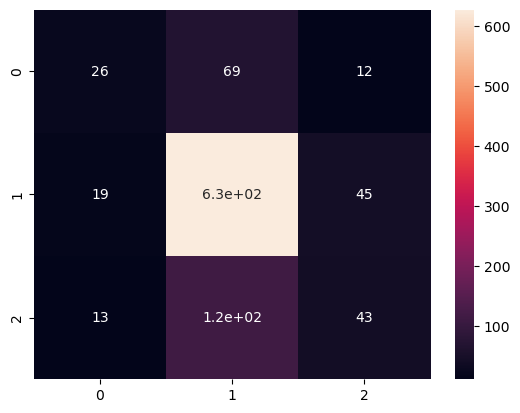

In [63]:
preds = model.predict(X_test)
conf = confusion_matrix(y_dict[f"{c}_test"], preds)
df_fig = pd.DataFrame(conf, index=labels_dict[c], columns=labels_dict[c])
sns.heatmap(df_fig, annot=True)

In [1]:
import pandas as pd
import seaborn as sns

In [3]:
# sns.heatmap(df_fig, annot=True)

_index = ["hidden verb(s)", "no hidden verbs", "both"]
_cols = [i for i in _index]
_data = [
    [   0,  104,    0],
    [   0, 5932,    0],
    [   0,  345,    0],
]
df_fig = pd.DataFrame(_data, columns=_cols, index=_index)
df_fig



,hidden verb(s),no hidden verbs,both
hidden verb(s),0,104,0
no hidden verbs,0,5932,0
both,0,345,0


In [5]:
df_fig.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

,hidden verb(s),no hidden verbs,both
hidden verb(s),0,104,0
no hidden verbs,0,5932,0
both,0,345,0


<AxesSubplot:>

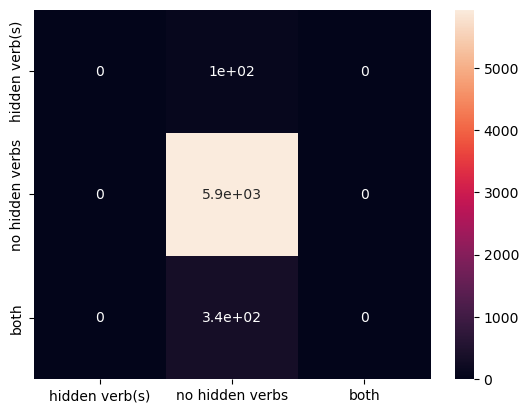

In [4]:
sns.heatmap(df_fig, annot=True)